# **Reducing High-Dimensional Gene Expression Data for Visualization**

This notebook builds on contents from the NBIS workshop "[Single Cell RNA-seq Analysis](https://nbisweden.github.io/workshop-scRNAseq/)".

First, let's download the data for this notebook.

In [1]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

In [2]:
from utils import download_file

if not os.path.exists(path="data"):
    os.makedirs(name="data")

download_file(
    # url="https://dataverse.harvard.edu/api/access/datafile/10811622",
    url="https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fdimensionality_reduction%2Fscanpy_covid_qc.h5ad&dl=1",
    save_filename="data/scanpy_covid_qc.h5ad",
)

Downloading: https://seafile.cloud.uni-hannover.de/d/5d6029c6eaaf410c8b01/files/?p=%2Fdimensionality_reduction%2Fscanpy_covid_qc.h5ad&dl=1 -> data/scanpy_covid_qc.h5ad
Total size: 186,343,792 bytes


100%|██████████| 186M/186M [00:05<00:00, 35.0MiB/s] 

Download completed: data/scanpy_covid_qc.h5ad


The data consists of single-cell RNA sequencing (scRNA-seq) data of peripheral blood mononuclear cells (PBMCs).
More specifically, it is divided into 8 PBMC 10x datasets from 4 COVID-19 patients and 4 healthy controls.

> A PBMC is any peripheral blood cell (peripheral blood is the fluid that travels through the heart, arteries, capillaries, and veins) having a round nucleus.
> These cells consist of lymphocytes, monocytes, and dendritic cells, whereas erythrocytes and platelets have no nuclei, and granulocytes have multi-lobed nuclei.

<img src="images/hematopoietic_differentiation.webp" width="600" />

scRNA-seq data of PBMCs is highly valuable for several reasons, particularly in the context of understanding immune responses and disease mechanisms.
PBMCs include key immune cells such as lymphocytes (e.g., T cells, B cells, NK cells), all of which play crucial roles in immune responses.
By analyzing their gene expression at single-cell resolution, we can understand how individual cell types contribute to immunity or disease.
This data helps identify cell type-specific responses to infections, such as those caused by COVID-19, and differentiate these responses from those in healthy controls.
Also, comparing PBMCs from COVID-19 patients and healthy controls can highlight dysregulated genes or pathways that could serve as biomarkers or therapeutic targets.

# Data Preparation

The data is already quality-controlled and filtered accordingly.

Before quality control (QC), all 8 samples were subsampled to 1500 cells per sample.
QC metrics included: number of UMIs, number of genes expressed, mitochondrial and ribosomal expression, sex, and cell cycle state.
For example, only cells with at least 200 detected genes were retained.
Also, genes needed to be expressed in at least 3 cells.

Furthermore, in the original data, quite a lot of cells had a high proportion of mitochondrial reads and a low proportion of ribosomal reads.

> Mitochondrial transcripts are upregulated during apoptosis or cell death processes.
> By filtering out such cells, we focus on viable cells, improving the reliability of the biological interpretations.
> High mitochondrial content could also indicate technical issues during sample preparation, such as prolonged handling or harsh dissociation protocols, leading to cellular stress.

> Ribosomal transcripts are involved in maintaining basic cellular machinery, and their low expression could indicate: i) cells with altered or arrested protein synthesis; ii) faulty capture of transcripts during library preparation, leading to underrepresentation of other transcripts and potential biases in clustering or differential gene expression analyses.

The bulk of the cells are below 20% mitochondrial reads and this was used as a cutoff for filtering.
Also, cells with less than 5% ribosomal reads were filtered out.

##### ❓ Loading the QC-filtered data

Load the QC-filtered data into an `AnnData` object using [`scanpy.read_h5ad`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.read_h5ad.html).
The `sample` column in the `adata.obs` DataFrame provides the sample name for each cell.

In [ ]:
import scanpy as sc

# YOUR CODE

Print the number of cells per sample.

In [ ]:
# YOUR CODE

sample
ctrl_19     1133
ctrl_13     1121
covid_17    1084
ctrl_14     1030
ctrl_5      1017
covid_1      876
covid_15     591
covid_16     370
Name: count, dtype: int64


##### ❓ Normalization and log-transformation

Before further processing the data, we need to normalize and log-transform the data.

Normalize the data using [`scanpy.pp.normalize_total`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.normalize_total.html).
This normalizes each cell by total counts over all genes, so that every cell has the same total count after normalization.
Use the parameter `target_sum=1e4`.

Then, logarithmize the data matrix `adata.X` using [`scanpy.pp.log1p`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.log1p.html).

In [ ]:
# YOUR CODE

# Feature Selection

We first need to define which features (i.e., genes) are important in our dataset to distinguish cell types.
For this purpose, it is common to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

Number of genes: 19468
Number of highly variable genes: 2626


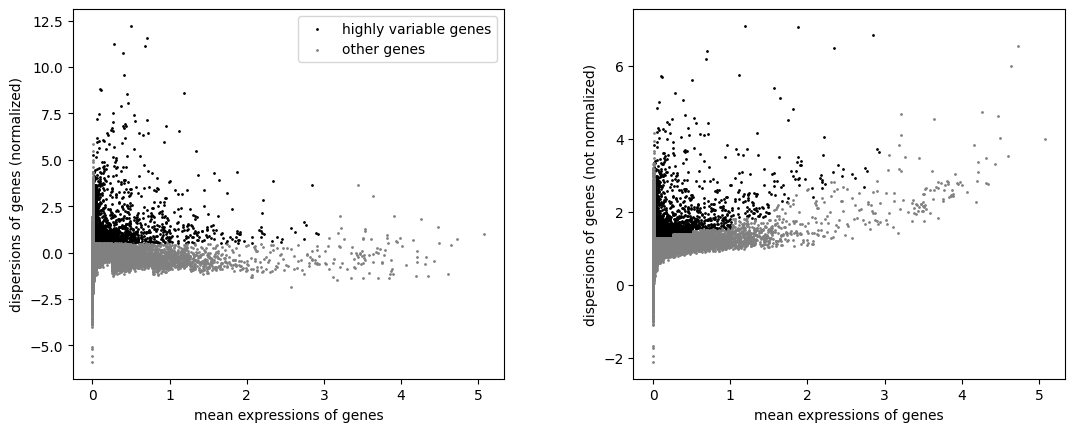

In [6]:
# Compute highly variable genes.
sc.pp.highly_variable_genes(adata)
print(f"Number of genes: {adata.n_vars}")
print(f"Number of highly variable genes: {sum(adata.var.highly_variable)}")

# Plot the highly variable genes. The term "dispersions of genes" refers to the
# variability or spread of gene expression levels across different cells. Dispersion is
# a measure of how much the expression of a gene varies from cell to cell.
sc.pl.highly_variable_genes(adata)

##### ❓ Subset the dataset for highly variable genes

Subset the dataset for highly variable genes.
The `highly_variable` column in the `adata.var` DataFrame (generated by `sc.pp.highly_variable_genes`) provides this information for each gene.

In [ ]:
# YOUR CODE
adata = adata[:, highly_variable_mask].copy()  # type: ignore

# PCA

Now that the genes have been selected, we proceed with PCA.
Since each gene has a different expression level, it means that genes with higher expression values will naturally have higher variation that will be captured by PCA.
This means that we need to give each gene a similar weight when performing PCA.

The common practice is to standardize (i.e., center and scale) each gene before performing PCA.

##### ❓ Standardizing the data

Use the function [`sc.pp.scale`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.scale.html) to standardize the expression values of each gene to have a mean of 0 and a variance of 1.
Use this function to also clip values that exceed the standard deviation 10 to mitigate the effect of extreme outliers.

In [ ]:
# YOUR CODE

Also, we need to remove the effects of certain variables or confounding factors from the gene expression data.
This is done to ensure that the downstream analyses (such as clustering, dimensionality reduction, or differential expression analysis) are not biased or influenced by these unwanted factors.

"Regressing out" in this context means:
1. Identifying confounding factors: Common confounding factors in scRNA-seq data include cell cycle effects, batch effects, mitochondrial gene expression, and total counts per cell.
2. Modeling the relationship: For each gene the relationship between its expression levels and the confounding factors is modeled using linear regression, where the gene expression is the dependent variable, and the confounding factors are the independent variables.
3. After modeling the relationship, the estimated effects of the confounding factors are subtracted from the gene expression data.

In [9]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

##### ❓ Run the PCA

Run the PCA with [`scanpy.tl.pca`](https://scanpy.readthedocs.io/en/1.9.x/generated/scanpy.tl.pca.html).

In [10]:
sc.tl.pca(adata)

Make 2-dimensional plots of the components 1 and 2, 3 and 4, 5 and 6, 7 and 8 using [`scanpy.pl.pca`](https://scanpy.readthedocs.io/en/stable/api/generated/scanpy.pl.pca.html).

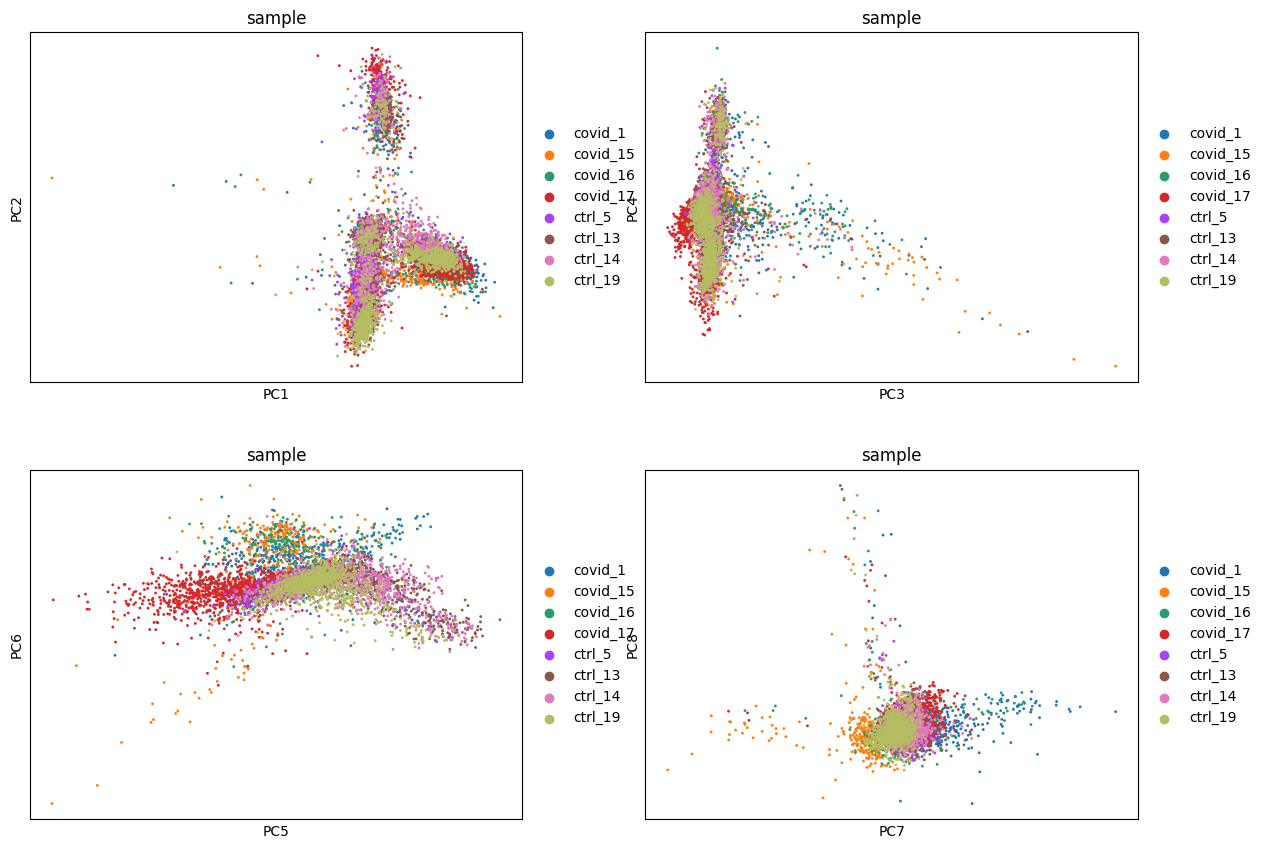

In [11]:
sc.pl.pca(adata, color="sample", components=["1,2", "3,4", "5,6", "7,8"], ncols=2)

Plot the amount of variance explained by each princicap component (PC) using [`scanpy.pl.pca_variance_ratio`](https://scanpy.readthedocs.io/en/stable/api/generated/scanpy.pl.pca_variance_ratio.html).

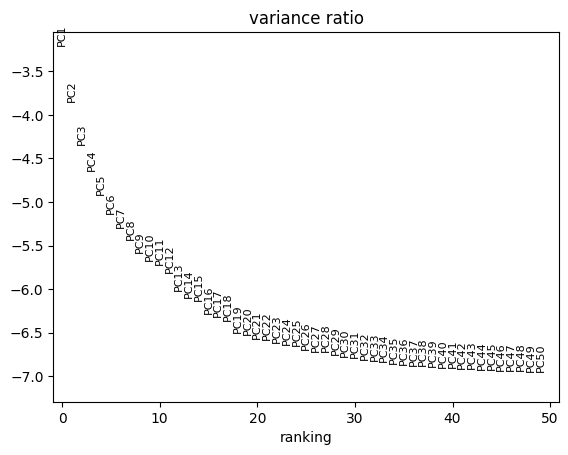

In [ ]:
# YOUR CODE

Based on this plot, we can see that the top 8 PCs retain a lot of information, while other PCs contain progressively less.
However, it is still advisable to use more PCs since they might contain information about rare cell types.

# t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique used primarily for visualizing high-dimensional data in 2 or 3 dimensions.
It preserves local structures by modeling pairwise similarities in both high and low dimensions.

The key steps are:
1. Model high-dimensional similarities:
    - Compute the conditional probability $P_{j|i}$ that point $i$ picks $j$ as its neighbor:
        $$P_{j|i} = \frac{\exp(-\| \mathbf{x}_i - \mathbf{x}_j \|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\| \mathbf{x}_i - \mathbf{x}_k \|^2 / 2\sigma_i^2)}$$
    - Symmetrize to obtain $P_{ij}$ (where $N$ is the numbe of data points):
        $$P_{ij} = \frac{P_{j|i} + P_{i|j}}{2N}$$
2. Model low-dimensional similarities:
    - In low-dimensional space, use a Student’s t-distribution with one degree of freedom (Cauchy distribution) for similarity, where $\mathbf{y}_i$ and $\mathbf{y}_j$ are low-dimensional embeddings:
        $$Q_{ij} = \frac{(1 + \| \mathbf{y}_i - \mathbf{y}_j \|^2)^{-1}}{\sum_{k \neq l} (1 + \| \mathbf{y}_k - \mathbf{y}_l \|^2)^{-1}}$$
3. Minimize the "difference" between the high- and low-dimensional models:
    - Minimize the Kullback-Leibler (KL) divergence between the high-dimensional and low-dimensional similarity distributions:
        $$\text{KL}(P \| Q) = \sum_{i \neq j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}$$
    - This optimization is typically performed using gradient descent.

##### ❓ Running t-SNE

Make a 2-dimensional t-SNE plot using [`scanpy.tl.tsne`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.tsne.html) and [`scanpy.pl.tsne`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.tsne.html) from scanpy.

In [ ]:
# YOUR CODE

Color the cells based on the sample they belong to.

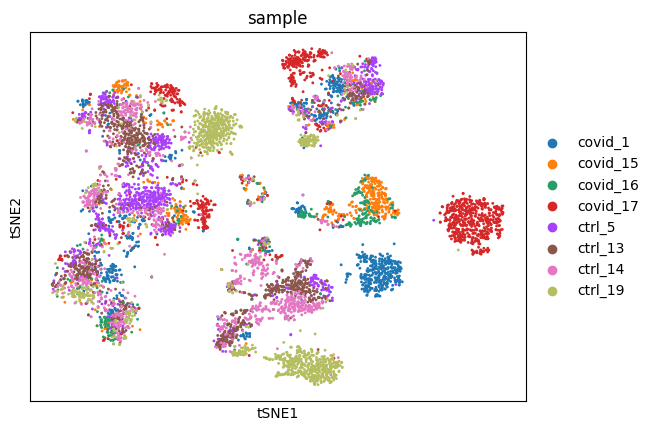

In [ ]:
# YOUR CODE

# UMAP

UMAP (Uniform Manifold Approximation and Projection) is a popular technique for reducing the dimensions of complex data, making it easier to visualize and analyze.

The key steps are:
1. For each data point, UMAP identifies its closest neighbors based on their positions in the original high-dimensional space.
2. UMAP builds a network (graph) where each point is connected to its neighbors with certain strengths, indicating how closely they are related. This graph represents the structure of the data, capturing both local (close neighbors) and some global (overall shape) relationships.
3. Next, UMAP starts by placing all points randomly or using a simple layout in the lower-dimensional space.
4. Finally, UMAP adjusts the positions of the points in the low-dimensional space to make the new graph (based on these positions) as similar as possible to the original high-dimensional graph. This step ensures that the reduced dimensions accurately represent the structure and relationships of the original data.

Further reading:
- [McInnes, L., Healy, J., Melville, J. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv 1802.03426 (2018).](https://doi.org/10.48550/arXiv.1802.03426)
- [Healy, J., McInnes, L. Uniform manifold approximation and projection. Nat Rev Methods Primers 4, 82 (2024).](https://doi.org/10.1038/s43586-024-00363-x)

##### ❓ Running UMAP

Make a 2-dimensional UMAP plot using [`sc.pp.neighbors`](https://scanpy.readthedocs.io/en/stable/generated/sc.pp.neighbors.html), [`sc.tl.umap`](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html), and [`sc.pl.umap`](https://scanpy.readthedocs.io/en/stable/generated/sc.pl.umap.html) from scanpy.
Color the cells based on the sample they belong to.

In [ ]:
# YOUR CODE

In [ ]:
# YOUR CODE

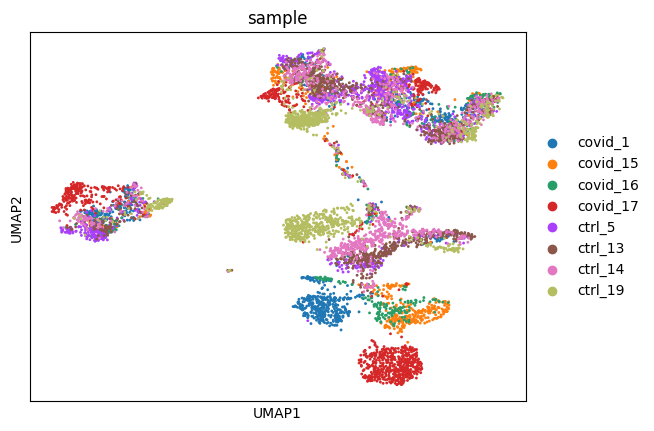

In [ ]:
# YOUR CODE

# Genes of Interest

To further investigate cell type-specific responses to COVID-19, let's plot some marker genes for different cell types onto the UMAP embeddings.

Markers                  | Cell Type
--                       | --
CD3E                     | T cells
CD3E, CD4                | CD4+ T cells
CD3E, CD8A               | CD8+ T cells
GNLY, NKG7               | NK cells
MS4A1                    | B cells
CD14, LYZ, CST3, MS4A7   | CD14+ Monocytes
FCGR3A, LYZ, CST3, MS4A7 | FCGR3A+ Monocytes
FCER1A, CST3             | DCs

##### ❓ Filtering for genes of interest

Not all of the genes of interest are included in our data, since we reduced it to only contain highly variable genes.

Make a list of genes of interest (from the table above) that are also highly variable.

In [ ]:
interest_genes = [
    "CD3E",
    "CD4",
    "CD8A",
    "GNLY",
    "NKG7",
    "MS4A1",
    "CD14",
    "LYZ",
    "CST3",
    "MS4A7",
    "FCGR3A",
]

# YOUR CODE

print(f"Genes of interest in highly variable genes: {interest_var_genes}")

Genes of interest in highly variable genes: ['CD3E', 'CD8A', 'MS4A1', 'CD14', 'CST3', 'MS4A7', 'FCGR3A']


##### ❓ Visualizing marker genes in the UMAP embedding

Use [`sc.pl.umap`](https://scanpy.readthedocs.io/en/stable/api/generated/scanpy.pl.umap.html) to make scatter plots in the UMAP basis, where cells are colored according the the expressions of the marker genes.
Use `use_raw=False` in `sc.pl.umap`.

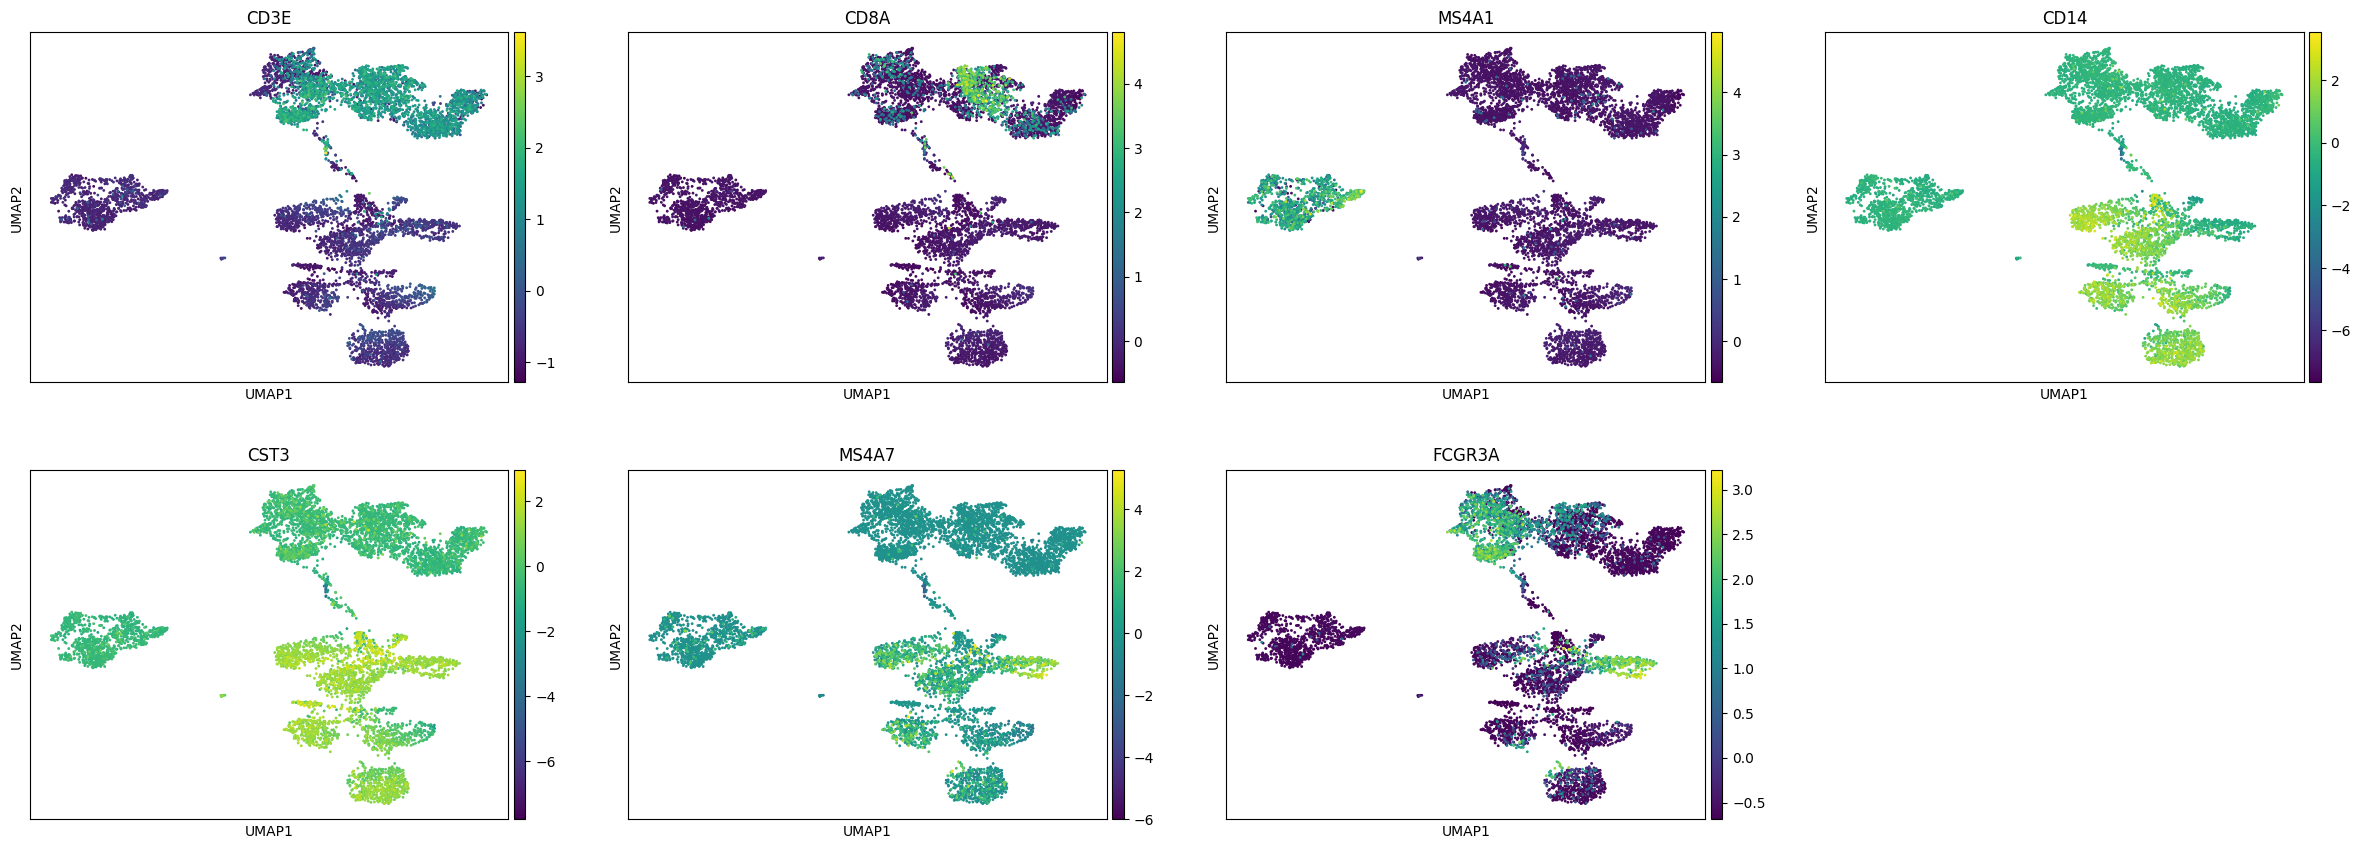

In [ ]:
# YOUR CODE

This side-by-side view helps confirm that the UMAP nicely separates major immune cell populations, with each cluster corresponding to cells of a similar type or state.